In [1]:
#IMPORTS
#Install+Import Packages
!pip install mechanize
import random
import re
import mechanize
import numpy as np
from random import *
import matplotlib.pyplot as plt
!pip install Bio
from Bio import SeqIO
from Bio.Seq import Seq
from collections import Counter 
from Bio.Cluster import kcluster
import statistics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import difflib
import seaborn as sns; sns.set_theme()
from collections import defaultdict
import collections
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from collections import OrderedDict
import matplotlib.pyplot as plt
from itertools import filterfalse
from matplotlib.pyplot import figure
import scipy.stats as stats
import pylab
from itertools import permutations
#!pip install ipython-autotime

In [14]:
#Upload Data and Define Parameters
leu_aa = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/Leu_S5_L001_R1_001.fastq').readlines()
ala_aa = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/Ala_S3_L001_R1_001.fastq').readlines()
gly_aa = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/Gly_S1_L001_R1_001.fastq').readlines()
phe_aa = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/Phe_S7_L001_R1_001.fastq').readlines()

leu_rna = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/LeuNaOH_S6_L001_R1_001.fastq').readlines()
ala_rna = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/AlaNaOH_S4_L001_R1_001.fastq').readlines()
gly_rna = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/GlyNaOH_S2_L001_R1_001.fastq').readlines()
phe_rna = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/PheNaOH_S8_L001_R1_001.fastq').readlines()

ctrl_8a = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/8actrl_S9_L001_R1_001.fastq').readlines()
ctrl_5b = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/CP1.3/5bctrl_S10_L001_R1_001.fastq').readlines()


In [15]:
#Upload Data and Define Parameters
file_type = '.fastq'

#Take the reverse complement? Enter 'yes' or 'no'
rc = 'no'

#Quality Cutoff - what fraction of positions should have <1% error probability?
quality_cutoff = 0.9


#Position motif1 starts at
motif_start = 1
#Motif1 define
motif = 'AAAGCCTG'
#Position motif2 starts at
motif2_start = 21
#Motif2 define
motif2 = 'TAGGCAAAAGATCGGAAGAGCACACGTCT'

In [227]:
def preprocess_seqs(list_of_seqs):

    if file_type == '.fastq':
        seqs = list_of_seqs[1::4]
        qualities = list_of_seqs[3::4]
        print('Total seqs: '+str(len(seqs)))

        #Filter by quality
        high_quality = []
        acceptable_quals_1_percent_error = [5,6,7,8,9,':',';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
        for seq in range(len(qualities)):
            overlap=0
            for char in list(set(qualities[seq]).intersection(acceptable_quals_1_percent_error)):
                overlap+=qualities[seq].count(char)
            if overlap/len(qualities[1])>quality_cutoff:
                high_quality.append(seqs[seq].strip("\n"))
        print('High quality seqs: '+str(len(high_quality)))
    
    if file_type == '.fasta':
        high_quality = list_of_seqs[1::2]
        print('Total seqs: '+str(len(high_quality)))
    
    #Take RC if desired
    pre_trim = []
    if rc == 'yes':
        rc_seqs = []
        for sequence in high_quality:
            rc_seqs.append(str(Seq(sequence).reverse_complement()).strip('\n'))
        pre_trim = rc_seqs
    else:
        for sequence in high_quality:
            pre_trim.append(str(Seq(sequence)).strip('\n'))
    if rc == 'yes':
        print('Reverse Comp = '+str(rc)) 

    #Trim to keep only seqs with constant region
    trimmed = []
    for seq in pre_trim:
        if motif in seq:
            if motif2 in seq:
                trimmed.append('GCCTG'+seq[(motif_start-1)+len(motif):(motif2_start-1)]+'TAGGC')
    print('Seqs after trimming: '+str(len(trimmed))) 
    
    #All processed seqs
    processed_seqs = trimmed
    #Unique seqs
    processed_seqs_unique = list(set(trimmed))
    
    return processed_seqs, processed_seqs_unique


def rscape_format(title, num_seqs_to_analyze, top_seqs):
    #Create file for R-Scape Covariation
    f = open("/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/aminoacylation/"+str(title)+".txt", "w")
    f.write('# STOCKHOLM 1.0\n')
    f.write('\n')
    counter = 0
    for seq in top_seqs[:num_seqs_to_analyze]:
      counter+=1
      f.write(str(counter)+'\t'+seq[0]+'\n')
    #f.write('#=GC SS_cons	(((((((((,)))))))))\n')
    f.write('//')

def make_heatmap(seqs_to_analyze):
  heatmap_data = []

  for position in range(len(seqs_to_analyze[0])):
      options = []
      for seq in seqs_to_analyze:
          options.append(seq[position])
      raw_options = [(k, v) for k, v in Counter(options).items()]
      nuc_list = []
      for element in raw_options:
          nuc_list.append(element[0])
      if 'A' not in nuc_list:
            raw_options.append(('A', 0))
      if 'C' not in nuc_list:
            raw_options.append(('C', 0))
      if 'G' not in nuc_list:
            raw_options.append(('G', 0))
      if 'T' not in nuc_list:
            raw_options.append(('T', 0))    
      raw_options = sorted(raw_options, key=lambda x: x[0])        
      
      heatmap_data_position = []
      for element in raw_options:
          heatmap_data_position.append(element[1]/len(seqs_to_analyze))
      heatmap_data.append(heatmap_data_position)


  fig, ax = plt.subplots(figsize = (30,6));
  im = ax.imshow(np.array(heatmap_data).transpose(), interpolation='nearest', cmap='YlOrRd');
  im.set_clim(0,1)
  cbar = fig.colorbar(im, orientation='vertical',)
  y_label_list = ['', 'A', 'C', 'G', 'T', ''];
  ax.set_yticks(range(-1, 1+len(heatmap_data[0])));
  ax.set_yticklabels(y_label_list);
  ax.set_xticks(range(len(heatmap_data)));
  ax.set_xticklabels(range(1, len(heatmap_data)+1));
  ax.grid(False)
  plt.show()
  return heatmap_data

def enrichment(seq_half1, seq_half2):

    #Find avg counts of any left half
    frequency_dict_half1 = [(k,v) for k,v in dict(Counter(half_1)).items()]
    all_counts = []
    for element in frequency_dict_half1:
        all_counts.append(element[1])
    mean_counts_half1 = np.mean(all_counts)

    #Find avg counts of any right half
    frequency_dict_half2 = [(k,v) for k,v in dict(Counter(half_2)).items()]
    all_counts = []
    for element in frequency_dict_half2:
        all_counts.append(element[1])
    mean_counts_half2 = np.mean(all_counts)
    print('In control, half 1 of top seq has: '+str(half_1.count(seq_half1))+' counts ('+str(round(mean_counts_half1,1))+' average)')
    print('In control, half 2 of top seq has: '+str(half_2.count(seq_half2))+' counts ('+str(round(mean_counts_half2,1))+' average)')

    #Enrichment of our two halves
    enrichment_half1 = half_1.count(seq_half1)/mean_counts_half1
    enrichment_half2 = half_2.count(seq_half2)/mean_counts_half2

    #Total enrichment score is the average enrichment of both halves
    enrichment = np.mean([enrichment_half1, enrichment_half2])
    return enrichment

def get_info(aa, rna, title):
    print(title)
    print('AA ONLY:')
    aa_ctrl_processed_seqs, aa_ctrl_processed_seqs_unique = preprocess_seqs(aa)
    aa_ctrl_top_seqs = Counter(aa_ctrl_processed_seqs).most_common(100)
    print('Unique AA seqs '+str(len(aa_ctrl_processed_seqs_unique)))
    print(aa_ctrl_top_seqs[:10])
    print('RNA ONLY:')
    rna_ctrl_processed_seqs, rna_ctrl_processed_seqs_unique = preprocess_seqs(rna)
    rna_ctrl_top_seqs = Counter(rna_ctrl_processed_seqs).most_common(100)
    print('Unique RNA seqs '+str(len(rna_ctrl_processed_seqs_unique)))
    print(rna_ctrl_top_seqs[:10])
    aa_rna_no_overlap = list(filterfalse(set(rna_ctrl_processed_seqs).__contains__, aa_ctrl_processed_seqs))
    print('AA NOT RNA: '+str(round(len(aa_rna_no_overlap))))
    aa_not_rna_top_seqs = Counter(aa_rna_no_overlap).most_common(10000)
    print('Unique AA only seqs '+str(len(set(aa_rna_no_overlap))))
    top_seqs = aa_not_rna_top_seqs[:10]
    rscape_format(title+'_rscape_1000',1000, aa_not_rna_top_seqs)
    print('R-Scape file saved')
    return aa_ctrl_processed_seqs, rna_ctrl_processed_seqs, aa_rna_no_overlap, aa_ctrl_top_seqs, rna_ctrl_top_seqs, aa_not_rna_top_seqs, top_seqs

def scaled_counts(aa_not_rna_top_seqs):
    aa_first_6_counts = []
    for seq in aa_not_rna_top_seqs[:1000]:
        aa_first_6_counts.append([seq[0][5:11], seq[1], ctrl_8a_6_subseqs.count(seq[0][5:11])])
    scaled_most_abundant_sorted1 = sorted(aa_first_6_counts, key=lambda x: x[1])[::-1]
    scaled_most_abundant_sorted2 = sorted(aa_first_6_counts, key=lambda x: x[2])[::-1]
    print(scaled_most_abundant_sorted1[:10])
    print(scaled_most_abundant_sorted2[:10])
    return scaled_most_abundant_sorted1, scaled_most_abundant_sorted2

def normalize_reads(aa_not_rna_top_seqs, control_normalized_counts, control_subseqs):
    aa_6_counts = []
    for seq in aa_not_rna_top_seqs[:1000]:
        aa_6_counts.append([seq[0][5:11], seq[1], control_normalized_counts[control_subseqs.index(seq[0][5:11])], seq[1]/control_normalized_counts[control_subseqs.index(seq[0][5:11])]])
    normalized_aa_6_counts = sorted(aa_6_counts, key=lambda x: x[3])[::-1]
    print(normalized_aa_6_counts[:10])
    return normalized_aa_6_counts

def find_representation(aa_not_rna_top_seqs, total_enrichment):
    corrected_error_reads = []
    for seq in range(len(total_enrichment)):
        corrected_error_reads.append([aa_not_rna_top_seqs[seq][0],aa_not_rna_top_seqs[seq][1]/total_enrichment[seq][1]])
    representation_scale_1 = corrected_error_reads[:10]
    representation_scale_2 = sorted(corrected_error_reads, key=lambda x: x[1])[::-1][:10]
    print('Old Top 10')
    print(representation_scale_1)
    print('')
    print('Top 10 Scaled by Represenation')
    print(representation_scale_2)
    return corrected_error_reads

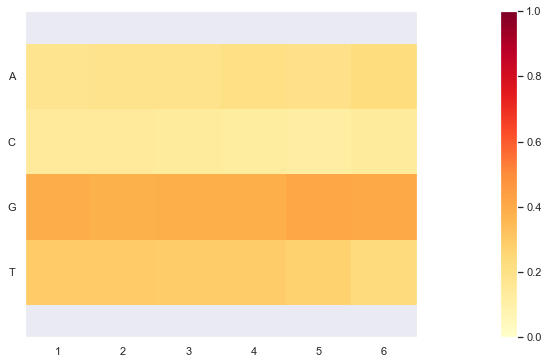

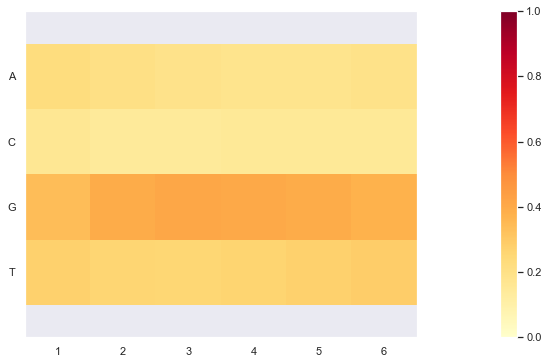

[[0.2240400175132753,
  0.16153751160735622,
  0.33799017524501745,
  0.27643229563435107],
 [0.2059525890619011,
  0.14222158783821712,
  0.3936589754733957,
  0.2581668476264861],
 [0.18796138739781917,
  0.14422470879368496,
  0.41266857730298767,
  0.2551453265055082],
 [0.1831035384193467,
  0.1498668060885896,
  0.40241721689678234,
  0.2646124385952814],
 [0.18341627547804665,
  0.14878265095176313,
  0.3933911442487655,
  0.2744099293214247],
 [0.19367725856298124,
  0.14903444437851127,
  0.3721234204773811,
  0.2851648765811264]]

In [26]:
#Find prevalence of sequences in control
#8a prevalence
motif_ctrl_1 = 'AAAGCCTG'
len_half_1 = 6
half_1 = []
for seq in ctrl_8a[1::4]:
    if motif_ctrl_1 in seq:
        sub = seq[seq.index(motif_ctrl_1)+len(motif_ctrl_1):seq.index(motif_ctrl_1)+len(motif_ctrl_1)+len_half_1]
        if len(sub) == 6:
            half_1.append(sub)

#5b prevalence
motif_ctrl_2 = 'TAGGCAAAAGATCGGAAGAGCACACGTCT'
len_half_2 = 6
half_2 = []
for seq in ctrl_5b[1::4]:
    if motif_ctrl_2 in seq:
        sub = seq[seq.index(motif_ctrl_2)-6:seq.index(motif_ctrl_2)]
        if len(sub)==6:
            half_2.append(sub)

make_heatmap(half_1)
make_heatmap(half_2)

In [69]:
gly_aa_ctrl_processed_seqs, gly_rna_ctrl_processed_seqs, gly_aa_rna_no_overlap, gly_aa_ctrl_top_seqs, gly_rna_ctrl_top_seqs, gly_aa_not_rna_top_seqs, gly_top_seqs = get_info(gly_aa, gly_rna, 'Gly')
print('')
leu_aa_ctrl_processed_seqs, leu_rna_ctrl_processed_seqs, leu_aa_rna_no_overlap, leu_aa_ctrl_top_seqs, leu_rna_ctrl_top_seqs, aa_not_rna_top_seqs, leu_top_seqs = get_info(leu_aa, leu_rna, 'Leu')
print('')
phe_aa_ctrl_processed_seqs, phe_rna_ctrl_processed_seqs, phe_aa_rna_no_overlap, phe_aa_ctrl_top_seqs, phe_rna_ctrl_top_seqs, phe_aa_not_rna_top_seqs, phe_top_seqs = get_info(phe_aa, phe_rna, 'Phe')
print('')
ala_aa_ctrl_processed_seqs, ala_rna_ctrl_processed_seqs, ala_aa_rna_no_overlap, ala_aa_ctrl_top_seqs, ala_rna_ctrl_top_seqs, ala_aa_not_rna_top_seqs, ala_top_seqs = get_info(ala_aa, ala_rna, 'Ala')


Gly
AA ONLY:
Total seqs: 356811
High quality seqs: 347603
Seqs after trimming: 216113
Unique AA seqs 153628
[('GCCTGGGGGGTAGGCAATAGGC', 31), ('GCCTGGGTGGTAGGCAATAGGC', 29), ('GCCTGTTATGGGAGTAATAGGC', 28), ('GCCTGGGGGTAGGCAAATAGGC', 27), ('GCCTGATGTGGGAATGTTAGGC', 26), ('GCCTGTTTGTAGGTAGATAGGC', 26), ('GCCTGATAGTGGGGTGTTAGGC', 24), ('GCCTGATTGTAGGGGGTTAGGC', 24), ('GCCTGGATTGGGAGGTTTAGGC', 24), ('GCCTGAATGTGGGGGTTTAGGC', 24)]
RNA ONLY:
Total seqs: 574755
High quality seqs: 551138
Seqs after trimming: 332641
Unique RNA seqs 211879
[('GCCTGGTGGTAGGCAAATAGGC', 784), ('GCCTGGTAGGCAAAAGATAGGC', 739), ('GCCTGGTATTAGGCAAATAGGC', 609), ('GCCTGGGTGGTAGGCAATAGGC', 575), ('GCCTGGGGGGTAGGCAATAGGC', 525), ('GCCTGGGGGGGTAGGCATAGGC', 514), ('GCCTGGGGGGTTAGGCATAGGC', 505), ('GCCTGGGGGTAGGCAAATAGGC', 468), ('GCCTGGTGTTAGGCAAATAGGC', 449), ('GCCTGGTGTAGGCAAAATAGGC', 440)]
AA NOT RNA: 144422
Unique AA only seqs 118777
R-Scape file saved

Leu
AA ONLY:
Total seqs: 239837
High quality seqs: 233354
Seqs after

In [19]:
#UPDATES 3/28/22

In [135]:
#1. For each sequence that we see in the amino acid condition, 
#we should search the first 6 nts in the control 8a set and get 
#the number of reads of the sequence in the control set. 

#Get all 6nt subseqs from 8a control
ctrl_8a_6_subseqs = []
for seq in ctrl_8a[1::4]:
    ctrl_8a_6_subseqs.append(seq[8:][:6])

#Get all 6nt subseqs from 5b control
ctrl_5b_6_subseqs = []
for seq in ctrl_5b[1::4]:
    if 'TAGGCAAAAGATCGGAAGAGCACACGTCT' in seq:
        ctrl_5b_6_subseqs.append(seq[seq.index('TAGGCAAAAGATCGGAAGAGCACACGTCT')-6:seq.index('TAGGCAAAAGATCGGAAGAGCACACGTCT')])
    
print('[Seq, Reads in AA experiment, Reads of first 6 in Control]')
#Count occurances of first 6 randomized region of top 1000 aa sequences
print('Gly')
sorted_gly = scaled_counts(gly_aa_not_rna_top_seqs)
print('')
print('Leu')
sorted_leu = scaled_counts(leu_aa_not_rna_top_seqs)
print('')
print('Phe')
sorted_phe = scaled_counts(phe_aa_not_rna_top_seqs)
print('')
print('Ala')
sorted_ala = scaled_counts(ala_aa_not_rna_top_seqs)

[Seq, Reads in AA experiment, Reads of first 6 in Control]
Gly
[['ATTTGG', 21, 405], ['TAAGAG', 19, 230], ['GAATGA', 16, 219], ['TAAGAG', 14, 230], ['TGTTGT', 14, 610], ['GATTGT', 14, 397], ['TATGTG', 13, 342], ['ATTTGG', 13, 405], ['GTATAG', 13, 248], ['TTGAGT', 13, 319]]
[['AAGAGC', 5, 1553], ['TGGTGG', 6, 1158], ['GTGTGG', 5, 1149], ['GTGTGG', 5, 1149], ['GTGTGG', 5, 1149], ['GTGTGG', 6, 1149], ['GTGTGG', 6, 1149], ['GTGTGG', 7, 1149], ['GTGTGG', 7, 1149], ['GTGGTG', 6, 1078]]

Leu
[['AAGTGG', 17, 310], ['GACGGA', 12, 142], ['TTTGGG', 11, 671], ['GTAAGA', 10, 530], ['ATTGGG', 9, 457], ['GAAACA', 9, 121], ['GTTTGC', 9, 396], ['AGTTGT', 9, 361], ['AACTGG', 9, 206], ['AGGAGC', 9, 172]]
[['AAGAGC', 4, 1553], ['GGAAGA', 4, 1256], ['TCGGAA', 4, 1242], ['GTGGGG', 3, 1174], ['GTGGGG', 4, 1174], ['GTGGGG', 4, 1174], ['GTGGGG', 7, 1174], ['TGGTGG', 4, 1158], ['TGGTGG', 5, 1158], ['TGGTGG', 5, 1158]]

Phe
[['AGTTGG', 35, 508], ['TAATGG', 33, 300], ['TTTTGA', 30, 425], ['GATTGG', 29, 581], ['AT

In [156]:
#2. Since we have 4^6 possible combos in the control set, we have 4,096 possible sequences. 
#To get the number of reads that we should expect IF the synthesis was fully random, we should
#take # of reads in the control 8a set and divide it by 4,096. This will give us the # of 
#reads that each sequence should come up if truly random. Now, the matched sequence from the 
#amino acid experiment will have a certain number of reads. Divide this number by the expected
#number to get the fold enrichment. (you currently have a very similar thing, except you are 
#taking the average number of reads and not the number expected from an optimal data set, 
#correct?) 

#Divide all reads in control by 4,096

control_8a_subseqs = list(Counter(ctrl_8a_6_subseqs).keys())
control_8a_raw_counts = list(Counter(ctrl_8a_6_subseqs).values())
control_8a_normalized_counts = list(np.array(list(Counter(ctrl_8a_6_subseqs).values()))/4096)

#Divide experimental reads by expected to get fold enrichment
print('[Seq, Reads in AA Exp, Expected Reads, Enrichment of First 6]')
print('')
print('Gly Top 10 Normalized Reads')
gly_normalized_reads_first = normalize_reads(gly_aa_not_rna_top_seqs, control_8a_normalized_counts, control_8a_subseqs)
print('')
print('Leu Top 10 Normalized Reads')
leu_normalized_reads_first = normalize_reads(leu_aa_not_rna_top_seqs, control_8a_normalized_counts, control_8a_subseqs)
print('')
print('Phe Top 10 Normalized Reads')
phe_normalized_reads_first = normalize_reads(phe_aa_not_rna_top_seqs, control_8a_normalized_counts, control_8a_subseqs)
print('')
print('Ala Top 10 Normalized Reads')
ala_normalized_reads_first = normalize_reads(ala_aa_not_rna_top_seqs, control_8a_normalized_counts, control_8a_subseqs)


[Seq, Reads in AA Exp, Expected Reads, Enrichment of First 6]

Gly Top 10 Normalized Reads
[['ATCTTA', 5, 0.011962890625, 417.9591836734694], ['ATCTTT', 5, 0.0126953125, 393.84615384615387], ['AATTGA', 8, 0.0205078125, 390.0952380952381], ['AATCGT', 5, 0.012939453125, 386.41509433962267], ['GACGAA', 7, 0.01953125, 358.4], ['TAAGAA', 11, 0.031005859375, 354.7716535433071], ['ATCATT', 4, 0.01171875, 341.3333333333333], ['TAAGAG', 19, 0.05615234375, 338.3652173913043], ['AATGAA', 7, 0.02099609375, 333.3953488372093], ['ATATGA', 11, 0.033203125, 331.29411764705884]]

Leu Top 10 Normalized Reads
[['CCCCGG', 6, 0.003173828125, 1890.4615384615386], ['CCAGGC', 5, 0.0048828125, 1024.0], ['CCCAGG', 4, 0.00439453125, 910.2222222222222], ['AGACGT', 6, 0.011474609375, 522.8936170212766], ['CGTCCT', 3, 0.005859375, 512.0], ['CCCGAG', 5, 0.010009765625, 499.5121951219512], ['ACTAGC', 5, 0.010009765625, 499.5121951219512], ['ATTCAT', 5, 0.011474609375, 435.74468085106383], ['AACTAT', 3, 0.007568359375

In [157]:
#3. After we have the fold enrichment for the half of the sequence, we should then take the 
#second half (the following 6 nts) and check those against the 5b control set and get the 
#enrichment score.

#Divide all reads in control by 4,096

control_5b_subseqs = list(Counter(ctrl_5b_6_subseqs).keys())
control_5b_raw_counts = list(Counter(ctrl_5b_6_subseqs).values())
control_5b_normalized_counts = list(np.array(list(Counter(ctrl_5b_6_subseqs).values()))/4096)
    
#Divide experimental reads by expected to get fold enrichment
print('[Seq, Reads in AA Exp, Expected Reads, Enrichment of Second 6]')
print('')
print('Gly Top 10 Normalized Reads')
gly_normalized_reads_second = normalize_reads(gly_aa_not_rna_top_seqs, control_5b_normalized_counts, control_5b_subseqs)
print('')
print('Leu Top 10 Normalized Reads')
leu_normalized_reads_second = normalize_reads(leu_aa_not_rna_top_seqs, control_5b_normalized_counts, control_5b_subseqs)
print('')
print('Phe Top 10 Normalized Reads')
phe_normalized_reads_second = normalize_reads(phe_aa_not_rna_top_seqs, control_5b_normalized_counts, control_5b_subseqs)
print('')
print('Ala Top 10 Normalized Reads')
ala_normalized_reads_second = normalize_reads(ala_aa_not_rna_top_seqs, control_5b_normalized_counts, control_5b_subseqs)


[Seq, Reads in AA Exp, Expected Reads, Enrichment of Second 6]

Gly Top 10 Normalized Reads
[['TAAGAA', 11, 0.022216796875, 495.1208791208791], ['TAAGAG', 19, 0.03955078125, 480.39506172839504], ['GAATGA', 16, 0.033935546875, 471.48201438848923], ['GACGAA', 7, 0.014892578125, 470.0327868852459], ['AAAAGA', 11, 0.02392578125, 459.7551020408163], ['GATCGT', 9, 0.020263671875, 444.144578313253], ['GATCGA', 5, 0.012451171875, 401.5686274509804], ['GATCGA', 5, 0.012451171875, 401.5686274509804], ['TCTTTA', 6, 0.01513671875, 396.38709677419354], ['ATATGA', 11, 0.0283203125, 388.41379310344826]]

Leu Top 10 Normalized Reads
[['CCCCGG', 6, 0.00390625, 1536.0], ['GAAACA', 9, 0.01220703125, 737.28], ['CTTTAC', 5, 0.00830078125, 602.3529411764706], ['ACATTA', 7, 0.01220703125, 573.44], ['CCCGAG', 5, 0.009765625, 512.0], ['CAATAC', 3, 0.006103515625, 491.52], ['ACAAGA', 5, 0.01025390625, 487.6190476190476], ['ATCAGA', 7, 0.014404296875, 485.96610169491527], ['ACAATT', 4, 0.009033203125, 442.810810

In [179]:
#4. With the two enrichment scores in hand, we should multiply them to get the overall 
#enrichment score.

print('Gly')
gly_total_enrichment = []
for seq in range(len(gly_normalized_reads_first)):
    gly_total_enrichment.append([gly_aa_not_rna_top_seqs[seq][0], gly_normalized_reads_first[seq][3]*gly_normalized_reads_second[seq][3]])
print('Old Top 10, Reads in Exp')    
print(sorted(gly_aa_not_rna_top_seqs, key=lambda x: x[1])[::-1][:10])
print('New Top 10, Enrichment Score')    
print(sorted(gly_total_enrichment, key=lambda x: x[1])[::-1][:10])
print('')

print('Leu')
leu_total_enrichment = []
for seq in range(len(leu_normalized_reads_first)):
    leu_total_enrichment.append([leu_aa_not_rna_top_seqs[seq][0], leu_normalized_reads_first[seq][3]*leu_normalized_reads_second[seq][3]])
print('Old Top 10, Reads in Exp')    
print(sorted(leu_aa_not_rna_top_seqs, key=lambda x: x[1])[::-1][:10])
print('New Top 10, Enrichment Score')    
print(sorted(leu_total_enrichment, key=lambda x: x[1])[::-1][:10])
print('')

print('Phe')
phe_total_enrichment = []
for seq in range(len(phe_normalized_reads_first)):
    phe_total_enrichment.append([phe_aa_not_rna_top_seqs[seq][0], phe_normalized_reads_first[seq][3]*phe_normalized_reads_second[seq][3]])
print('Old Top 10, Reads in Exp')    
print(sorted(phe_aa_not_rna_top_seqs, key=lambda x: x[1])[::-1][:10])
print('New Top 10, Enrichment Score')    
print(sorted(phe_total_enrichment, key=lambda x: x[1])[::-1][:10])
print('')

print('Ala')
ala_total_enrichment = []
for seq in range(len(ala_normalized_reads_first)):
    ala_total_enrichment.append([ala_aa_not_rna_top_seqs[seq][0], ala_normalized_reads_first[seq][3]*ala_normalized_reads_second[seq][3]])
print('Old Top 10, Reads in Exp')    
print(sorted(ala_aa_not_rna_top_seqs, key=lambda x: x[1])[::-1][:10])
print('New Top 10, Enrichment Score')    
print(sorted(ala_total_enrichment, key=lambda x: x[1])[::-1][:10])


Gly
Old Top 10, Reads in Exp
[('GCCTGATTTGGAGGAGTTAGGC', 21), ('GCCTGTAAGAGGGGTTATAGGC', 19), ('GCCTGGAATGAGGGTTTTAGGC', 16), ('GCCTGTAAGAGGGTTTATAGGC', 14), ('GCCTGTGTTGTGGAATGTAGGC', 14), ('GCCTGGATTGTGGGGTTTAGGC', 14), ('GCCTGTATGTGAGTGTATAGGC', 13), ('GCCTGATTTGGGAGAATTAGGC', 13), ('GCCTGGTATAGGGGTATTAGGC', 13), ('GCCTGTTGAGTGGTTAATAGGC', 13)]
New Top 10, Enrichment Score
[['GCCTGATTTGGAGGAGTTAGGC', 206940.31845705316], ['GCCTGTAAGAGGGGTTATAGGC', 189201.74738841405], ['GCCTGGAATGAGGGTTTTAGGC', 183922.88866050018], ['GCCTGGATTGTGGGGTTTAGGC', 181627.76368697805], ['GCCTGTGTTGTGGAATGTAGGC', 164776.22857142857], ['GCCTGTAAGAGGGTTTATAGGC', 157569.90646048763], ['GCCTGGTATGGAAGTGTTAGGC', 137068.75816993462], ['GCCTGATTTGGGGGAATTAGGC', 135876.85592497868], ['GCCTGTTGAGTGGTTAATAGGC', 132153.6144036009], ['GCCTGGTATAGGGGTATTAGGC', 128679.20486815416]]

Leu
Old Top 10, Reads in Exp
[('GCCTGAAGTGGGAGTTTTAGGC', 17), ('GCCTGGACGGAGAGGTTTAGGC', 12), ('GCCTGTTTGGGGAAGGATAGGC', 11), ('GCCTGGTAAGAG

In [228]:
#5. With the multiplied enrichment score in hand, we then divide each of our sequences in the
#amino acid condition by their respective enrichment score. Sequences that were enriched by 
#synthesizer error would get diminished, while sequences that were underrepresented because of
#the synthesizer error would become enriched. 

print('Gly')
gly_corrected_error_reads = find_representation(gly_aa_not_rna_top_seqs, gly_total_enrichment)
print('')

print('Leu')
leu_corrected_error_reads = find_representation(leu_aa_not_rna_top_seqs, leu_total_enrichment)
print('')

print('Phe')
phe_corrected_error_reads = find_representation(phe_aa_not_rna_top_seqs, phe_total_enrichment)
print('')

print('ala')
ala_corrected_error_reads = find_representation(ala_aa_not_rna_top_seqs, ala_total_enrichment)
print('')


Gly
Old Top 10
[['GCCTGATTTGGAGGAGTTAGGC', 0.00010147853331132368], ['GCCTGTAAGAGGGGTTATAGGC', 0.00010042190551757812], ['GCCTGGAATGAGGGTTTTAGGC', 8.699297904968262e-05], ['GCCTGGATTGTGGGGTTTAGGC', 7.708072662353515e-05], ['GCCTGTGTTGTGGAATGTAGGC', 8.49637118252841e-05], ['GCCTGTAAGAGGGTTTATAGGC', 8.884945301094439e-05], ['GCCTGGTATGGAAGTGTTAGGC', 9.484291076660158e-05], ['GCCTGATTTGGGGGAATTAGGC', 9.567486612420334e-05], ['GCCTGTTGAGTGGTTAATAGGC', 9.837037041073755e-05], ['GCCTGGTATAGGGGTATTAGGC', 0.0001010264246916968]]

Top 10 Scaled by Represenation
[['GCCTGTTGTTTGTGCAATAGGC', 0.018679821491241456], ['GCCTGATCTGTTGTGGTTAGGC', 0.01565171778202057], ['GCCTGAGTGTTGGGATTTAGGC', 0.012818187475204466], ['GCCTGATCATTGAGGGTTAGGC', 0.012293954690297442], ['GCCTGAGTAGTGGGTATTAGGC', 0.011801462173461915], ['GCCTGTTGGGGGGTAGATAGGC', 0.011056337356567384], ['GCCTGTAGTGGGAATTGTAGGC', 0.011056337356567384], ['GCCTGTGAAGTGTTTTATAGGC', 0.009969115257263184], ['GCCTGTAACGTGAGGGATAGGC', 0.009230566024

In [222]:
representation_scale_2

[['GCCTGGAACGTAGGTTGTAGGC', 0.021530854701995852],
 ['GCCTGCGATGTGAAGTGTAGGC', 0.018426179885864258],
 ['GCCTGATGCGTTGGTATTAGGC', 0.014926493167877196],
 ['GCCTGATTTGCGGAGATTAGGC', 0.014834880828857422],
 ['GCCTGGTTTGGAAAAAGTAGGC', 0.014632701873779297],
 ['GCCTGTCATGTGGGTGGTAGGC', 0.014632701873779297],
 ['GCCTGTTCTGGAGGGAGTAGGC', 0.0141357421875],
 ['GCCTGATTAGCGAGGGTTAGGC', 0.013845849037170411],
 ['GCCTGAGTTTCGGACTTTAGGC', 0.012743825912475585],
 ['GCCTGAGGGGAGATTCTTAGGC', 0.012099146842956543]]

In [215]:
total_enrichment[seq][1]

IndexError: list index out of range

In [207]:
seq

1000